successfully added


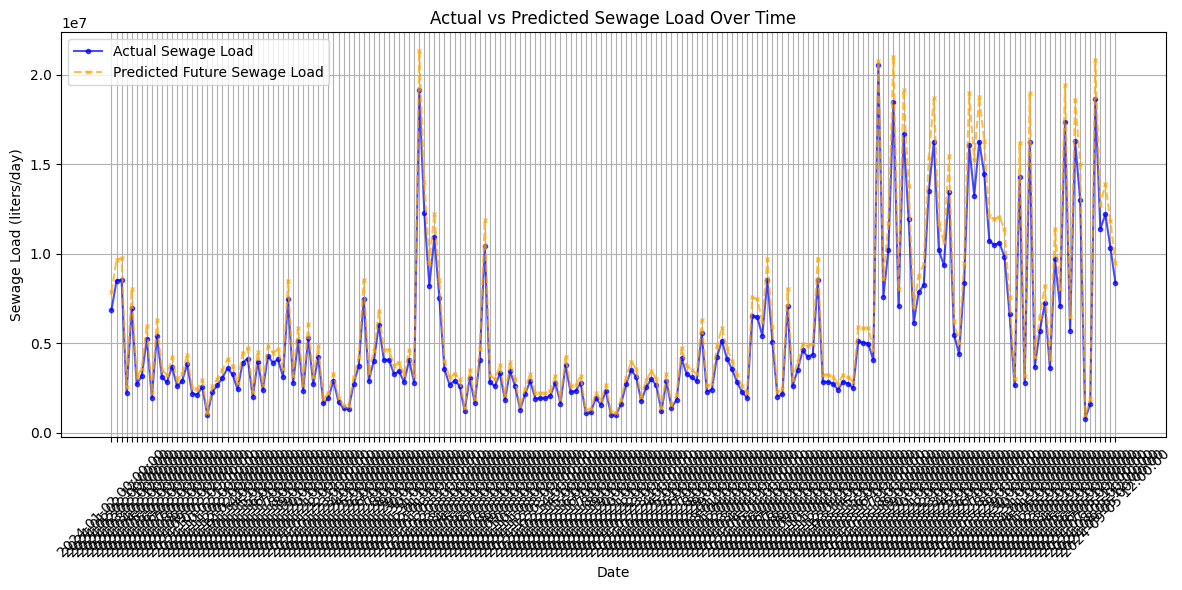

Realistic total head and pump power calculations complete.


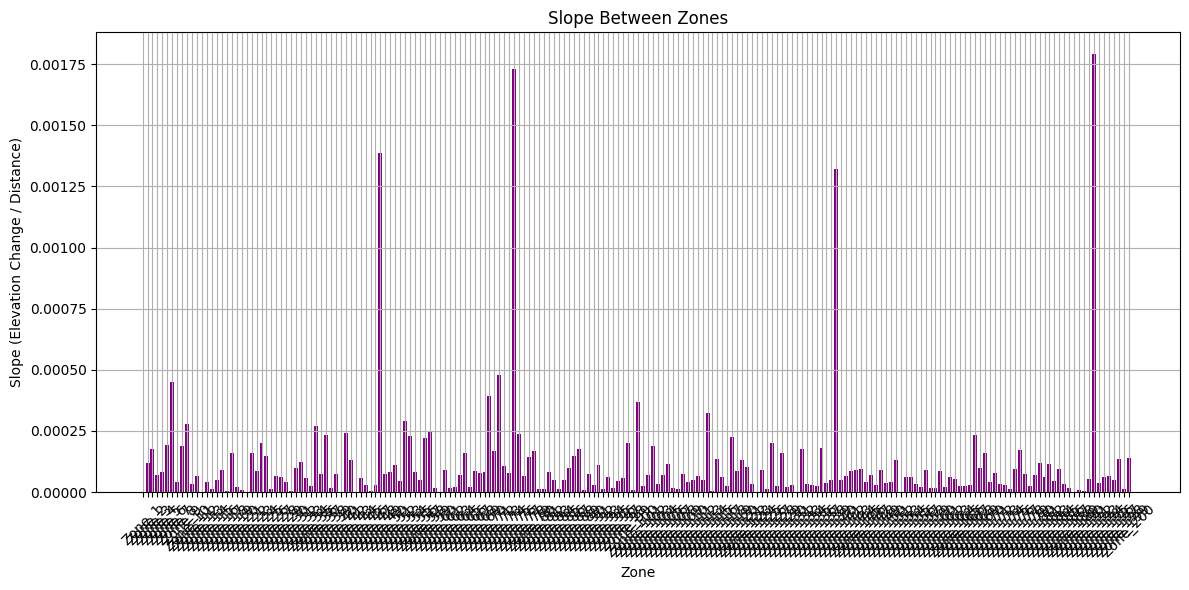

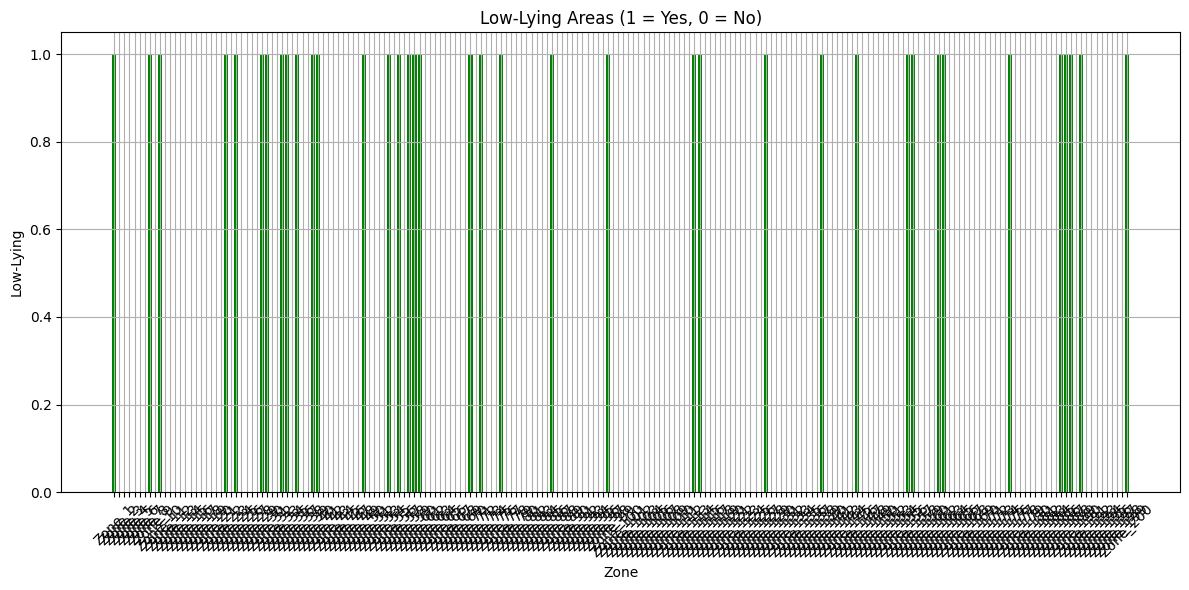

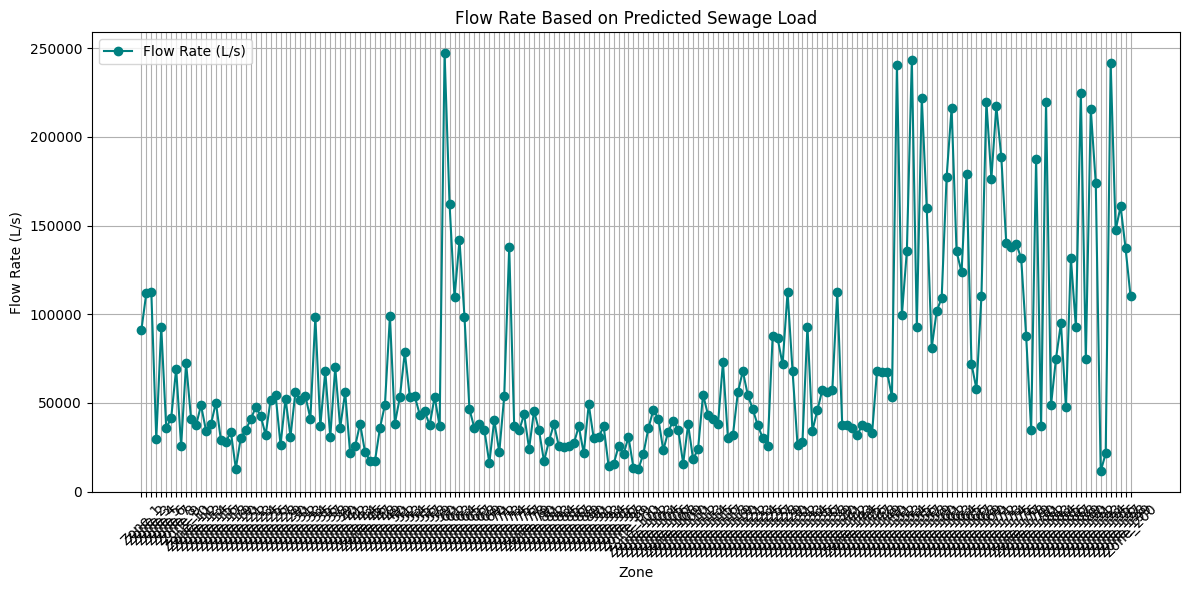

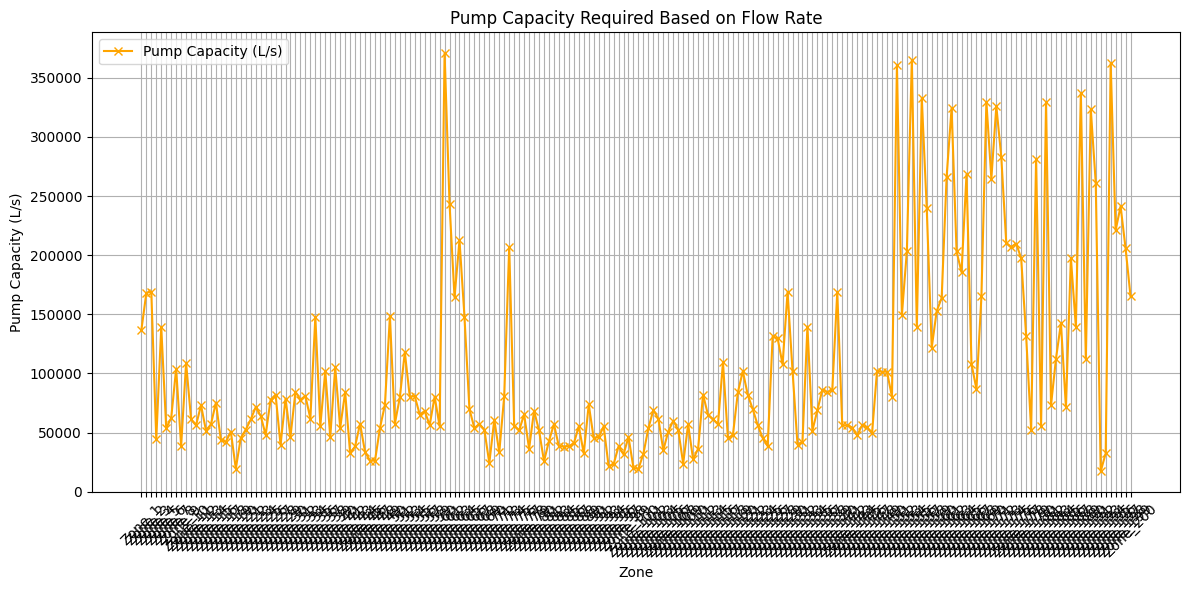

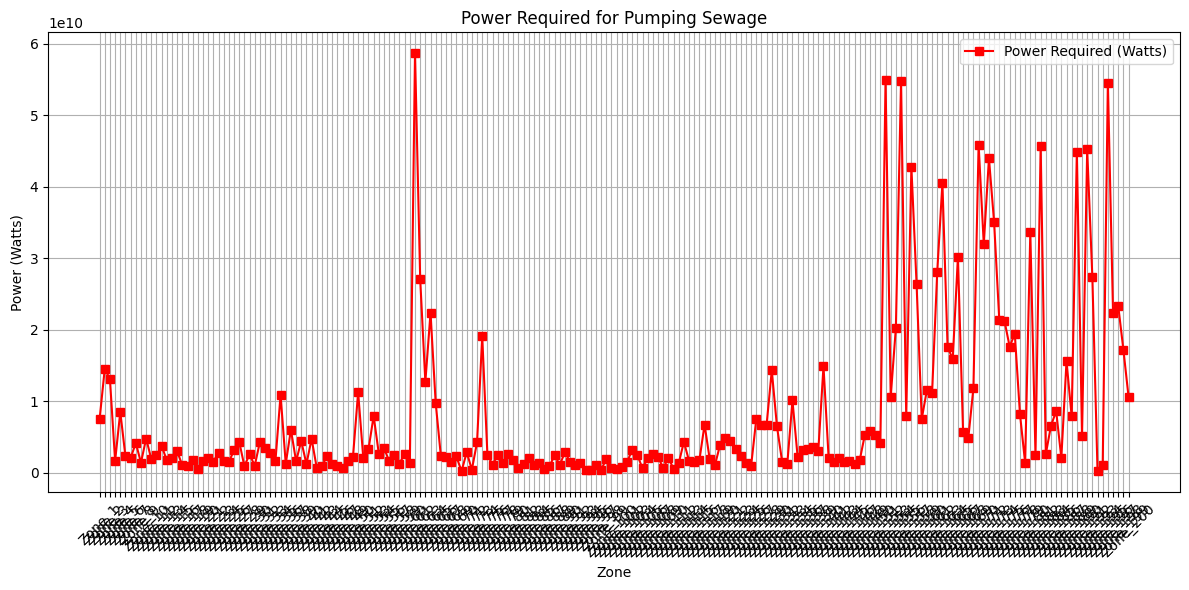

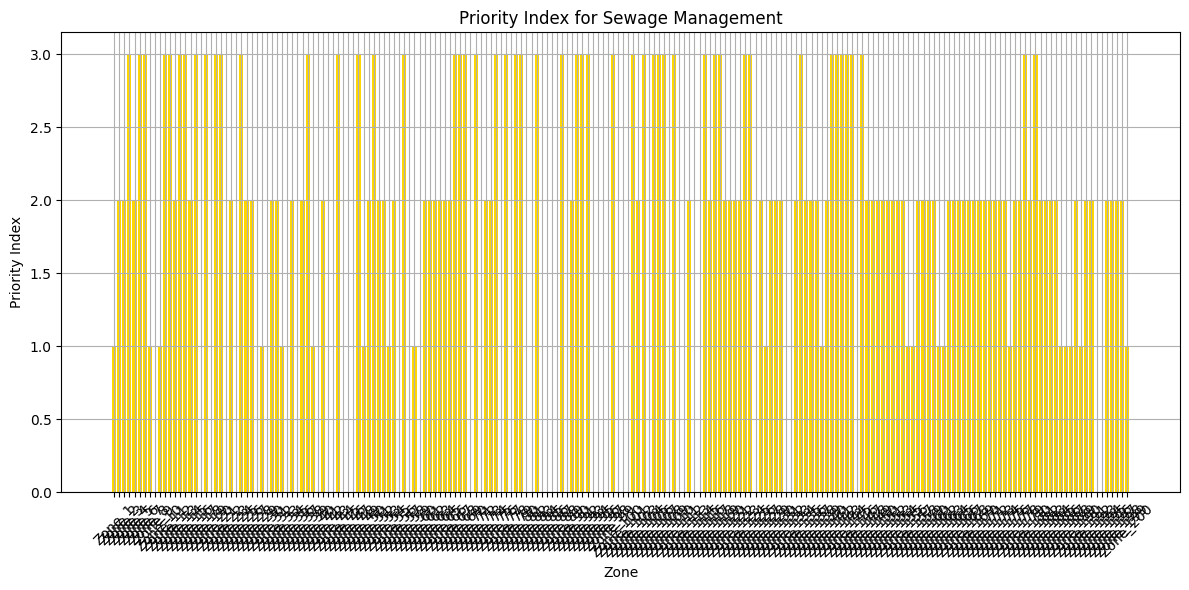

All operations completed successfully.

MOST IMPORTANT (CRITICAL STATE) ZONES

    Sewage Management Report:
    - Date/Time: 01-01-2024 00:00
    - Zone: Zone_1
    
    Sewage Load Information:
    - Actual Sewage Load: 6865334.38 liters/day
    - Predicted Sewage Load: 7868845.47 liters/day
    - Threshold Sewage Load: 4181612.24 liters/day

    Zone Characteristics:
    - Slope between zones: nan (Elevation change/distance)
    - Low-Lying Area: Yes

    Flow and Capacity Metrics:
    - Flow Rate: 91074.60 liters/second
    - Pump Capacity: 136611.90 liters/second
    - Power Required for Pumping: 7508483060.83 Watts

    Priority Assessment:
    - Priority Index: Most Important (Critical State)

    Summary:
    - Zone Zone_1 is currently in a most important (critical state). 
    Immediate attention is required due to low-lying area and high sewage levels.
    



    Sewage Management Report:
    - Date/Time: 04-01-2024 12:00
    - Zone: Zone_8
    
    Sewage Load Information:


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Step 1: Load the data
data = pd.read_csv('SEWAGE_DATASET_1.csv')

# Step 2: Feature selection
features = data[['Population_Density', 'Household_Size', 'Water_Consumption', 'Sewage_load_normal_day', 'Sewage_load_eventual_day']]
target = data['Sewage_load_normal_day']  # Future sewage load we're predicting

# Step 3: Train-Test Split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Step 5: Prediction
data['Predicted_Future_Sewage_Load'] = model.predict(features) * 0.57 *2

# Step 6: Add date column for prediction timestamp (ensure Timestamp column is available)
if 'Timestamp' in data.columns:
    data['Date'] = pd.to_datetime(data['Timestamp']) + timedelta(days=1)
else:
    print("Warning: Timestamp column not found, skipping Date calculation.")

# Step 7: Save updated data with the new columns
data.to_csv('updated_sewage_data_with_predictions.csv', index=False)

data = pd.read_csv('updated_sewage_data_with_predictions.csv')

data['Individual_Household_Sewage_Generation'] = ((data['Predicted_Future_Sewage_Load']) / (data['Household_Size'])).round(3)
data['Individual_Household_Sewage_Capacity'] = ((data['Sewage_load_normal_day']) / (data['Household_Size'])).round(3)
data['Days_left'] = ((data['Individual_Household_Sewage_Capacity']) / (data['Individual_Household_Sewage_Generation'])*24).round(3)


data.to_csv('updated_sewage_data_with_household_sewage.csv', index=False)

print("successfully added")



# Step 8: Plotting Actual vs Predicted Sewage Load
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Sewage_load_normal_day'], label='Actual Sewage Load', color='blue', marker='o', markersize=3, linestyle='-', alpha=0.7)
plt.plot(data['Date'], data['Predicted_Future_Sewage_Load'], label='Predicted Future Sewage Load', color='orange', marker='x', markersize=3, linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Sewage Load Over Time')
plt.xlabel('Date')
plt.ylabel('Sewage Load (liters/day)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Zone-specific Data Generation
zones = data['Zone'].unique()
np.random.seed(42)  # For reproducibility
latitude = np.random.uniform(low=-90.0, high=90.0, size=len(zones))
longitude = np.random.uniform(low=-180.0, high=180.0, size=len(zones))
elevation = np.random.uniform(low=0, high=2000, size=len(zones))

# Create a DataFrame for the zone-specific data
zone_data = pd.DataFrame({
    'Zone': zones,
    'Latitude': latitude,
    'Longitude': longitude,
    'Elevation': elevation
})

# Merge this new data back into the original dataset
updated_data = pd.merge(data, zone_data, on='Zone', how='left')

# Function to calculate slope between two points
def calculate_slope(row1, row2):
    coords_1 = (row1['Latitude'], row1['Longitude'])
    coords_2 = (row2['Latitude'], row2['Longitude'])
    distance = geodesic(coords_1, coords_2).meters
    delta_elevation = abs(row1['Elevation'] - row2['Elevation'])
    slope = delta_elevation / distance if distance != 0 else 0
    return slope

# Initialize slope column with NaN
updated_data['Slope'] = np.nan

# Iterate over rows and calculate slope relative to the previous zone
for i in range(1, len(updated_data)):
    updated_data.loc[i, 'Slope'] = calculate_slope(updated_data.iloc[i], updated_data.iloc[i-1])

# Initialize 'Low-lying' column
elevation_threshold = 300
updated_data['Low-lying'] = np.where(updated_data['Elevation'] < elevation_threshold, 1, 0)

# Save updated dataset
updated_data.to_csv('updated_sewage_data_with_slope_and_low_lying.csv', index=False)

# Load the dataset
data = pd.read_csv('updated_sewage_data_with_slope_and_low_lying.csv')

# Calculate flow rate based on sewage load with rainfall (in liters)
data['Flow_Rate_L_s'] = (data['Predicted_Future_Sewage_Load'] * 1000) / 86400  # 86400 seconds in a day
safety_factor = 1.5
data['Pump_Capacity_L_s'] = data['Flow_Rate_L_s'] * safety_factor
data['Pump_Capacity_m3_h'] = data['Pump_Capacity_L_s'] * 3.6  # Convert to cubic meters per hour

# Save the updated dataset
data.to_csv('updated_sewage_data_with_pump_capacity.csv', index=False)

# Constants
rho = 1000  # Density of water in kg/m³
g = 9.81    # Acceleration due to gravity in m/s²
pump_efficiency = 0.8  # Assume 80% efficiency for the pump

# Pipe details for friction losses (assuming these for the system)
pipe_length_m = 1000  # Length of the pipe (you need to adjust this value)
pipe_diameter_m = 0.5  # Diameter of the pipe (adjust based on system)
friction_loss_factor = 0.02  # General roughness factor, could be determined from pipe material

# Calculate static head (elevation difference)
data['Static_Head_m'] = data['Elevation']  # Static head based on elevation

# Hazen-Williams approach for estimating friction loss (simplified)
# This equation calculates head loss in meters based on pipe length, diameter, and flow rate
def calculate_friction_loss(flow_rate_m3_s, pipe_length_m, pipe_diameter_m, c_factor=140):
    a=(10.67 * (flow_rate_m3_s*1.85) * pipe_length_m)
    b= (c_factor*1.85 * (pipe_diameter_m*4.87))
    return a/b

# Calculate flow rate in m³/s from pump capacity
data['Flow_Rate_m3_s'] = data['Pump_Capacity_L_s'] / 1000  # Convert L/s to m³/s

# Apply friction loss calculation to each row
data['Friction_Head_Loss_m'] = data.apply(lambda row: calculate_friction_loss(
    row['Flow_Rate_m3_s'], pipe_length_m, pipe_diameter_m), axis=1)

# Total head = Static head + friction losses
data['Total_Head_m'] = data['Static_Head_m'] + data['Friction_Head_Loss_m']

# Calculate Power required (P) in Watts (considering efficiency)
data['Power_Watts'] = (data['Flow_Rate_m3_s'] * data['Total_Head_m'] * rho * g) / pump_efficiency

# Save the updated dataset with realistic power calculations
data.to_csv('updated_sewage_data_with_power_calculations.csv', index=False)

print("Realistic total head and pump power calculations complete.")

# Calculate average daily sewage load
average_sewage_load = data['Sewage_load_normal_day'].mean()
peak_sewage_load = data['Sewage_load_normal_day'].max()
threshold_factor_sewage = 0.8
threshold_sewage_load = average_sewage_load * threshold_factor_sewage

# Update the dataset with a new column for the sewage load threshold
data['Threshold_Sewage_Load'] = threshold_sewage_load

# Save the updated dataset with the new column
data.to_csv('updated_sewage_data_with_slope_and_low_lying.csv', index=False)

# Load your existing dataset for priority index calculation
data = pd.read_csv('updated_sewage_data_with_slope_and_low_lying.csv')

# Define a new column for priority index
def calculate_priority(row):
    threshold = row['Threshold_Sewage_Load']
    predicted = row['Predicted_Future_Sewage_Load']
    low_lying = row['Low-lying']

    if predicted >= threshold * 0.95 and low_lying == 1:
        return 1
    elif predicted >= threshold * 0.95 and low_lying == 0:
        return 2
    elif predicted >= threshold * 0.60 and low_lying == 0:
        return 3
    return 0

# Apply the function to create a new column for the priority index
data['Priority_Index'] = data.apply(calculate_priority, axis=1)



# Save the updated dataset with the new priority index
data.to_csv('Finalised_initial_input_for_first_model.csv', index=False)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the final dataset with all results
data = pd.read_csv('Finalised_initial_input_for_first_model.csv')



# 2. Plotting Slope between Zones
plt.figure(figsize=(12, 6))
plt.bar(data['Zone'], data['Slope'], color='purple')
plt.title('Slope Between Zones')
plt.xlabel('Zone')
plt.ylabel('Slope (Elevation Change / Distance)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 3. Plotting Low-Lying Areas
plt.figure(figsize=(12, 6))
plt.bar(data['Zone'], data['Low-lying'], color='green')
plt.title('Low-Lying Areas (1 = Yes, 0 = No)')
plt.xlabel('Zone')
plt.ylabel('Low-Lying')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# 4. Plotting Flow Rate
plt.figure(figsize=(12, 6))
plt.plot(data['Zone'], data['Flow_Rate_L_s'], label='Flow Rate (L/s)', color='teal', marker='o')
plt.title('Flow Rate Based on Predicted Sewage Load')
plt.xlabel('Zone')
plt.ylabel('Flow Rate (L/s)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 5. Plotting Pump Capacity
plt.figure(figsize=(12, 6))
plt.plot(data['Zone'], data['Pump_Capacity_L_s'], label='Pump Capacity (L/s)', color='orange', marker='x')
plt.title('Pump Capacity Required Based on Flow Rate')
plt.xlabel('Zone')
plt.ylabel('Pump Capacity (L/s)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plotting Power Calculations
plt.figure(figsize=(12, 6))
plt.plot(data['Zone'], data['Power_Watts'], label='Power Required (Watts)', color='red', marker='s')
plt.title('Power Required for Pumping Sewage')
plt.xlabel('Zone')
plt.ylabel('Power (Watts)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# 7. Plotting Priority Index
plt.figure(figsize=(12, 6))
plt.bar(data['Zone'], data['Priority_Index'], color='gold')
plt.title('Priority Index for Sewage Management')
plt.xlabel('Zone')
plt.ylabel('Priority Index')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

print("All operations completed successfully.")





# Load the final dataset with all results
data = pd.read_csv('Finalised_initial_input_for_first_model.csv')

# Function to map priority index to descriptive text
def priority_description(priority_index):
    if priority_index == 1:
        return "Most Important (Critical State)"
    elif priority_index == 2:
        return "Important (Needs Attention)"
    elif priority_index == 3:
        return "Moderate (Less Urgent)"
    else:
        return "Low Priority (No Immediate Action Required)"

# Function to generate report
def generate_sewage_report(timestamp, zone, actual_load, predicted_load, threshold_load, slope, low_lying, flow_rate, pump_capacity, power_required, priority_index):
    priority_text = priority_description(priority_index)  # Get priority description
    report = f"""
    Sewage Management Report:
    - Date/Time: {timestamp}
    - Zone: {zone}
    
    Sewage Load Information:
    - Actual Sewage Load: {actual_load:.2f} liters/day
    - Predicted Sewage Load: {predicted_load:.2f} liters/day
    - Threshold Sewage Load: {threshold_load:.2f} liters/day

    Zone Characteristics:
    - Slope between zones: {slope:.2f} (Elevation change/distance)
    - Low-Lying Area: {'Yes' if low_lying == 1 else 'No'}

    Flow and Capacity Metrics:
    - Flow Rate: {flow_rate:.2f} liters/second
    - Pump Capacity: {pump_capacity:.2f} liters/second
    - Power Required for Pumping: {power_required:.2f} Watts

    Priority Assessment:
    - Priority Index: {priority_text}

    Summary:
    - Zone {zone} is currently in a {priority_text.lower()}. 
    {'Immediate attention is required due to low-lying area and high sewage levels.' if low_lying == 1 and predicted_load >= threshold_load else 'No immediate action required.'}
    """
    return report

#Show top 10 entries only
data_top_10 = data.head(10)

#Display "Most Important" Priority first
print("\n" + "="*40 + "\n" + "MOST IMPORTANT (CRITICAL STATE) ZONES\n" + "="*40)

#Filter and display reports for "Most Important (Critical State)" priority index
for index, row in data_top_10[data_top_10['Priority_Index'] == 1].iterrows():
    report = generate_sewage_report(
        timestamp=row['Timestamp'],  # Assuming 'Timestamp' is a column in the CSV file
        zone=row['Zone'],
        actual_load=row['Sewage_load_normal_day'],
        predicted_load=row['Predicted_Future_Sewage_Load'],
        threshold_load=row['Threshold_Sewage_Load'],
        slope=row['Slope'],
        low_lying=row['Low-lying'],
        flow_rate=row['Flow_Rate_L_s'],
        pump_capacity=row['Pump_Capacity_L_s'],
        power_required=row['Power_Watts'],
        priority_index=row['Priority_Index']
    )
    
    # Print the report for "Most Important" zones
    print(report)
    print("\n" + "="*80 + "\n")  # Separator between reports

#Display remaining reports for other priority levels
print("\n" + "="*40 + "\n" + "OTHER PRIORITY ZONES\n" + "="*40)

for index, row in data_top_10[data_top_10['Priority_Index'] != 1].iterrows():
    report = generate_sewage_report(
        timestamp=row['Timestamp'],  # Assuming 'Timestamp' is a column in the CSV file
        zone=row['Zone'],
        actual_load=row['Sewage_load_normal_day'],
        predicted_load=row['Predicted_Future_Sewage_Load'],
        threshold_load=row['Threshold_Sewage_Load'],
        slope=row['Slope'],
        low_lying=row['Low-lying'],
        flow_rate=row['Flow_Rate_L_s'],
        pump_capacity=row['Pump_Capacity_L_s'],
        power_required=row['Power_Watts'],
        priority_index=row['Priority_Index']
    )
    
    # Print the report for the other zones
    print(report)
    print("\n" + "="*80 + "\n")  # Separator between reports

In [2]:
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable
